In [30]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian#, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
import os
path = os.getcwd()
import json
from visuals import display_it

import matplotlib as mpl
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
mpl.rcParams['legend.fontsize'] = 10
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [31]:
from functions import ChesneyScott
from derivation import Grad, Grad_Hess
from equation import semilinear
from coeff import OU_drift_semi, custom_diff, zero_discount, f_driver, exponential_terminal

In [32]:
pde_params={'dim':2,
            'kappa':torch.tensor([0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device), # The first kappa=0 because the drift of wealth process is zero
            'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
            # 'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device), #Hung's coefficient
            'nu':torch.tensor([0.2,0.15,0.11,0.12,0.1,0.13,0.14,0.14,0.1]).to(device), # we do not like vanishing diffusion coefficient
            # 'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   Hung's params
            'lb':torch.tensor([0.,.6,1.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device), # New params Make closed form solution more sensitive to time
            'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
            'eta':torch.tensor([.5]).to(device),
            'T': 1.,#torch.tensor([1.]).to(device),
            }

In [33]:
cs = ChesneyScott(pde_params)

In [49]:
input = torch.Tensor([[0.,1.,2.],[0.2,.5,0.2]])
input

tensor([[0.0000, 1.0000, 2.0000],
        [0.2000, 0.5000, 0.2000]])

In [50]:
cs(input)

tensor([-0.2467, -1.1051])

In [36]:
t0 = time.time()
num_samples = 2**16
num_time_intervals = 30
max_dim = 10
size = num_samples* max_dim * num_time_intervals
iid = torch.randn(size=[size]).to(device)
print("It takes {:.0f} ms to generate {:,} iid samples.".format(round(1000*(time.time()-t0),6),size))

It takes 202 ms to generate 19,660,800 iid samples.


In [37]:
sim_params={'num_samples':2**12,
        'num_time_intervals': 10,
        'iid':iid,
        'start' : torch.tensor([.9]),  
        'end' : torch.tensor([1.1]),
        'num_neurons':4
        }

In [38]:
m = OU_drift_semi(pde_params)
optimal_diff = m.lb_norm/pde_params['eta']
semi_diff_opt = custom_diff(pde_params,optimal_diff)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params)

In [39]:
semi = semilinear(semi_diff_opt,m,F,k,g,pde_params,sim_params)

In [40]:
semi.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 1.50E+00.
Training this epoch takes 16.06 ms. So far: 16.43 ms in training.
At epoch 1666, mean loss is 3.24E-03.
Training this epoch takes 11.93 ms. So far: 19,929.08 ms in training.
Training took 2655 epochs and 32,127.26 ms and the final loss is 2.94E-03.


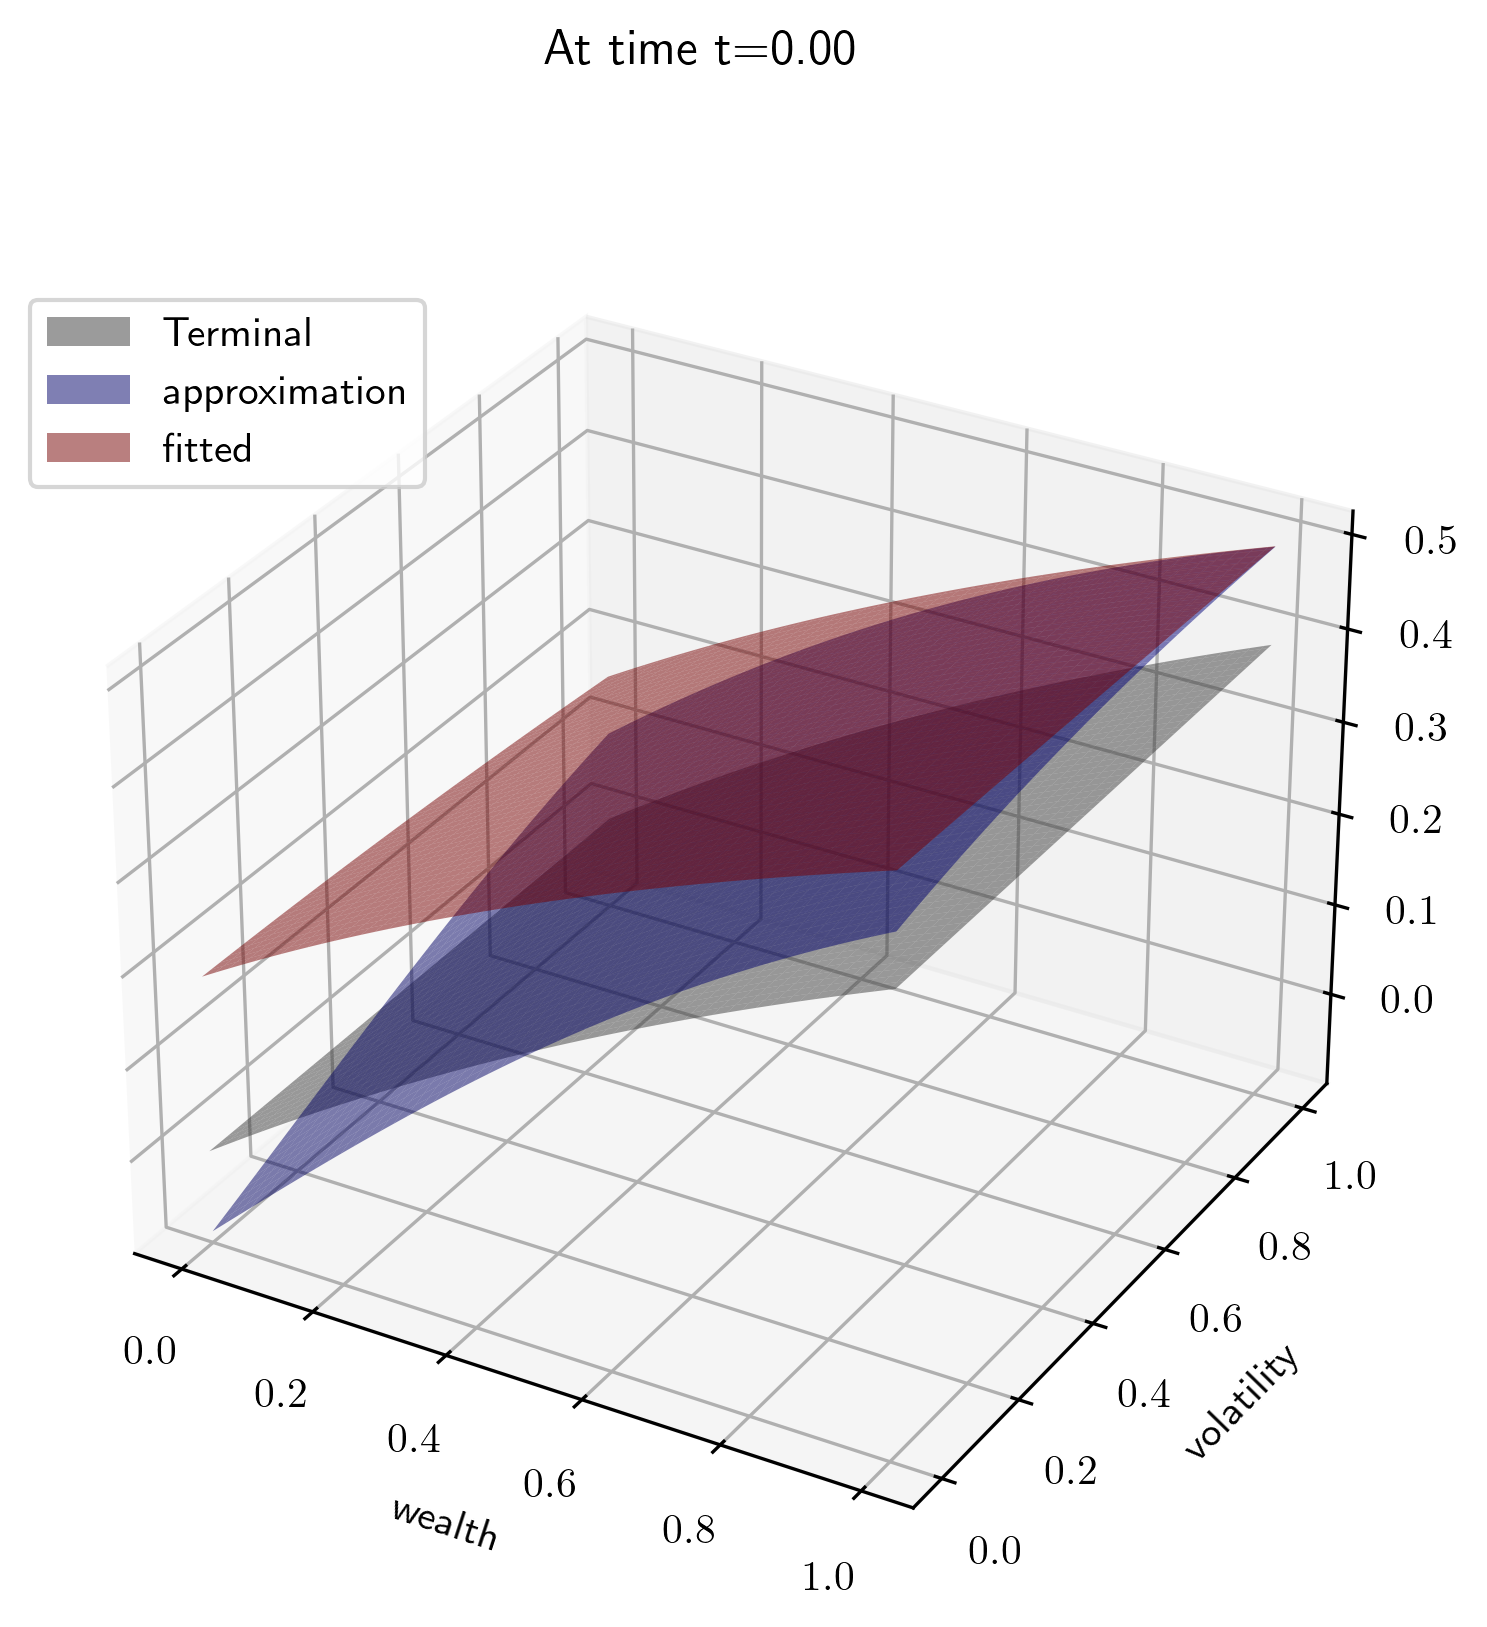

In [47]:
display_it(semi)

In [41]:
semi.Y0(torch.tensor([[1.,0.]]))-1,1-torch.exp(-m.eta-0.5*m.lb_norm**2)

(tensor([[-0.5489]], grad_fn=<SubBackward0>), tensor([0.4934]))

In [42]:
m = OU_drift_semi(pde_params)
optimal_cs_diff = lambda x: torch.sqrt(torch.pow(m.lb*x[:,1:],2).sum(axis=1))/pde_params['eta']
semi_diff_opt = custom_diff(pde_params,optimal_cs_diff)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params)

In [43]:
semics = semilinear(semi_diff_opt,m,F,k,g,pde_params,sim_params)

In [44]:
semics.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 1.74E+00.
Training this epoch takes 16.92 ms. So far: 17.15 ms in training.
At epoch 1666, mean loss is 8.50E-04.
Training this epoch takes 10.95 ms. So far: 20,427.33 ms in training.
At epoch 3332, mean loss is 7.63E-04.
Training this epoch takes 12.09 ms. So far: 39,515.67 ms in training.
At epoch 4998, mean loss is 7.56E-04.
Training this epoch takes 10.63 ms. So far: 59,318.57 ms in training.
Training took 5000 epochs and 59,347.65 ms and the final loss is 7.56E-04.


In [48]:
semics.Yt(torch.tensor([[0.,1.,2.]]))

tensor([[0.5041]], grad_fn=<AddmmBackward0>)

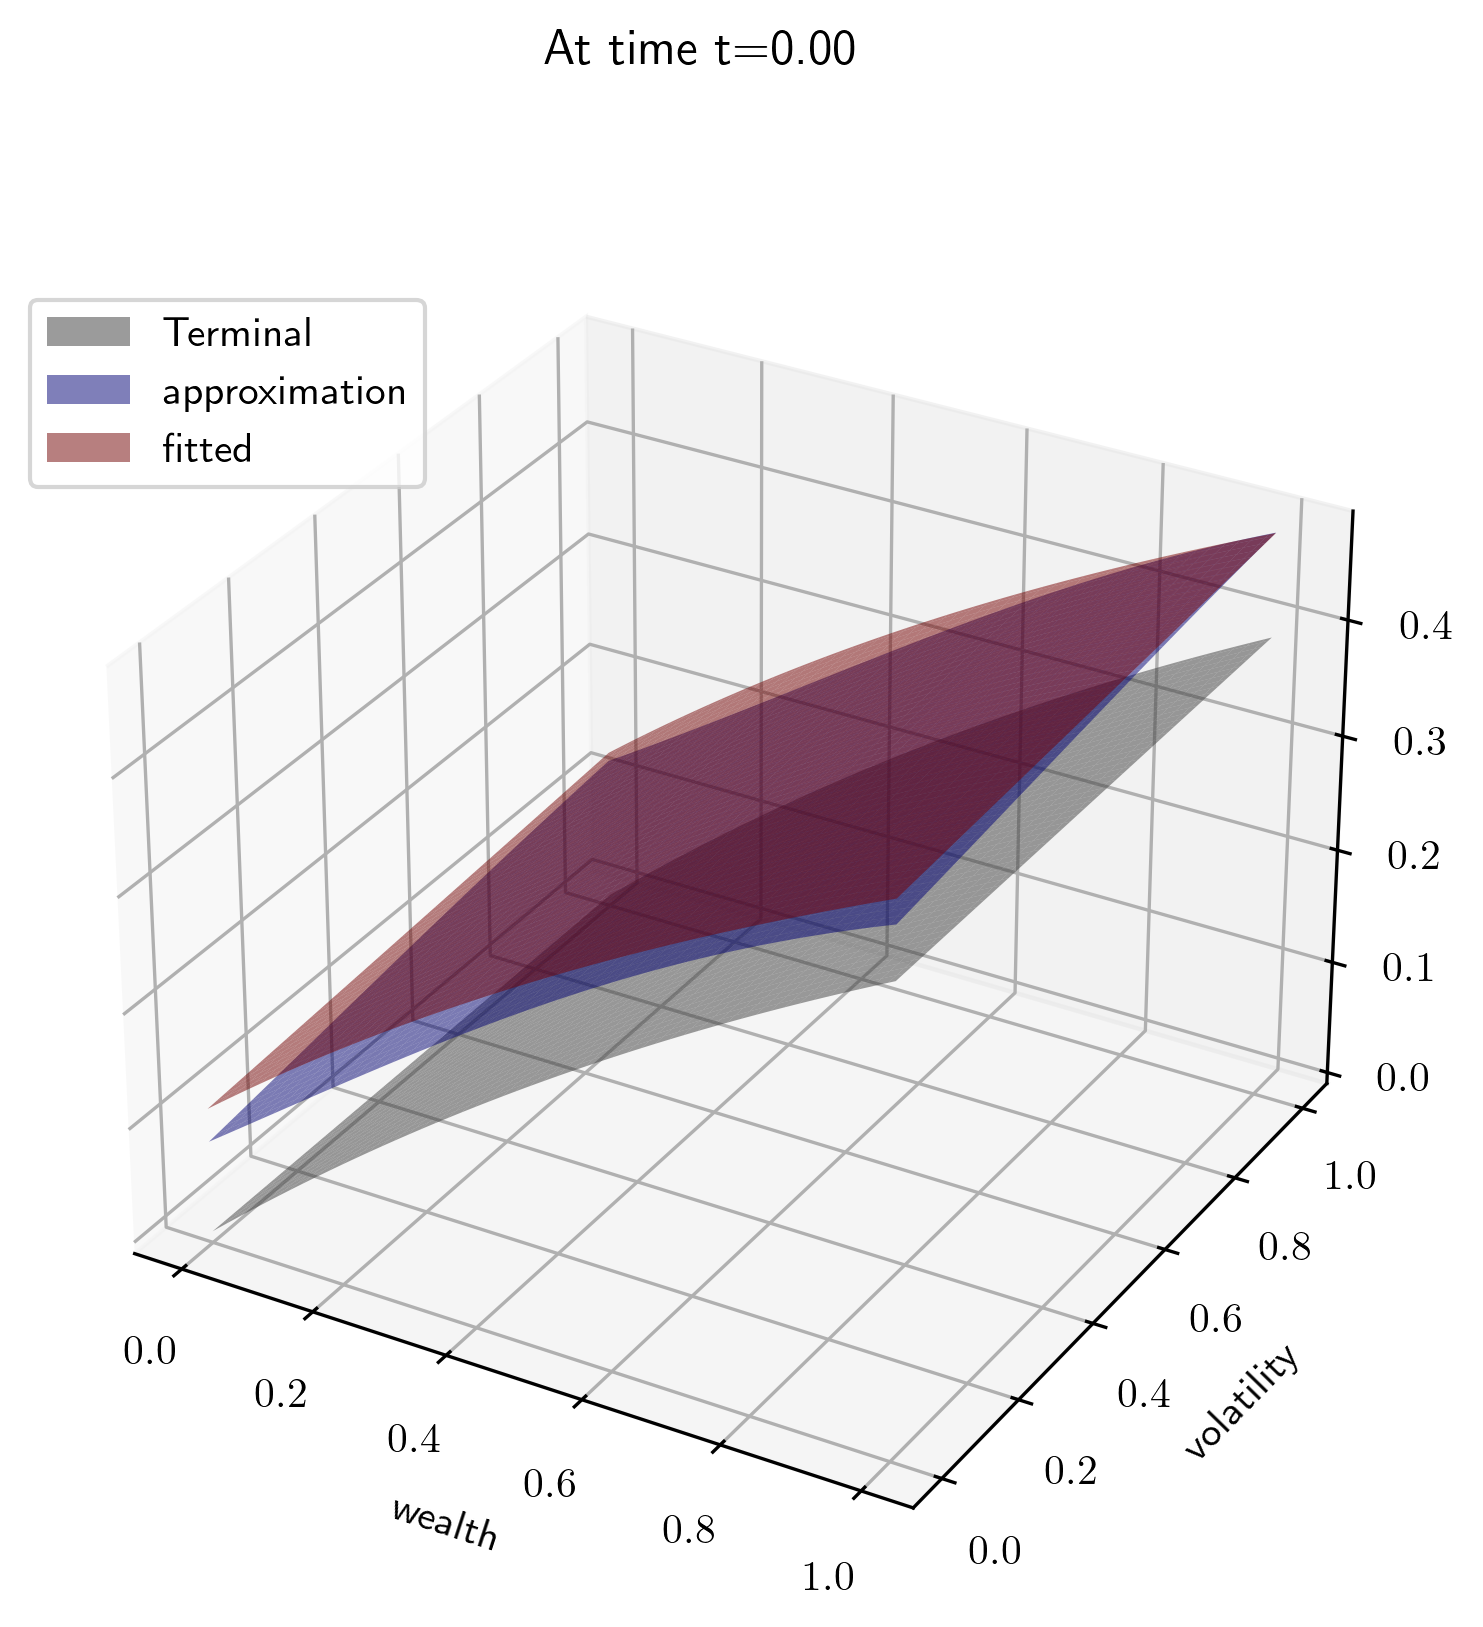

In [46]:
display_it(semics)